In [1]:
# change current working directory
%cd ..

/Users/alpha/Developer/qtrader


# Week 8

Market Simulation
* **Moments**: evaluation criterion
* **Arbitrage**: evaluation criterion
* **`VAE`**: vanilla variational autoencoder architecure
* **`GAN`**: vanilla generative adversarial network

In [2]:
import qtrader
# simulation tests
from qtrader.simulation.tests import Arbitrage, Moments

import yaml

import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [3]:
# fetch configuration file
config = yaml.load(open('config/simulation.yaml', 'r'))

## Data Source

In [4]:
# original returns time-series
try:
    # use cached CSV file
    returns = qtrader.envs.data_loader.Finance.Returns(
        config['tickers'], start_date=config['start_date'], csv=config['csv_file_returns'])
except:
    # download data
    returns = qtrader.envs.data_loader.Finance.Returns(
        config['tickers'], start_date=config['start_date'])
    # cache to CSV file
    returns.to_csv(config['csv_file_returns'])

In [5]:
# remove infinities and NaN values
returns = qtrader.utils.pandas.clean(returns)
# original rolling data
rolling_returns = qtrader.utils.rolling2d(
    returns.values, config['window']).mean(axis=1)

## `AAFT` Simulation

In [6]:
# generated returns time-series
returns_gen = qtrader.simulation.AAFT(
    returns, random=np.random.normal, random_state=13)
# generated rolling data
rolling_returns_gen = qtrader.utils.rolling2d(
    returns_gen.values, config['window']).mean(axis=1)

## `VAE` Simulation

In [7]:
# VAE-friendly data
returns_vae = qtrader.utils.rolling2d(
    returns.values, config['window'])
# get dimensions
num_samples, timesteps, input_dim = returns_vae.shape
# initialize model
vae, encoder, generator = qtrader.contrib.generators.VAE(input_dim,
                                                         timesteps=timesteps,
                                                         batch_size=config['batch_size'],
                                                         intermediate_dim=config['intermediate_dim'],
                                                         latent_dim=config['latent_dim'],
                                                         epsilon_std=1.)

In [8]:
# fit model
vae.fit(returns_vae, returns_vae, epochs=config['num_epochs'], verbose=0);

In [9]:
# latent variable
mu = np.zeros(config['latent_dim'])
Sigma = np.diag(np.ones(config['latent_dim']))
Z = np.random.multivariate_normal(mu, Sigma, config['num_samples'])
# generate data
returns_vae_gen = generator.predict(Z, batch_size=config['batch_size'])[:, -1, :]

## Tests

Evaluation metrics for simulated data, comparison basis for generative models.

### Moments



(False,
 {'first': (False,
   array([ 2.61247479,  2.05711303,  6.30069864,  0.06619121,  2.93352188,
           2.37320331,  2.36845093, 62.82657437])),
  'second': (False, 0.7203235164794043)})

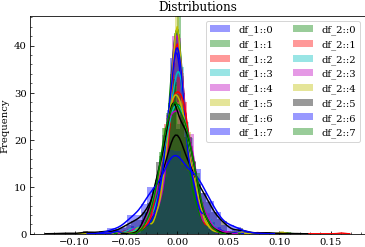

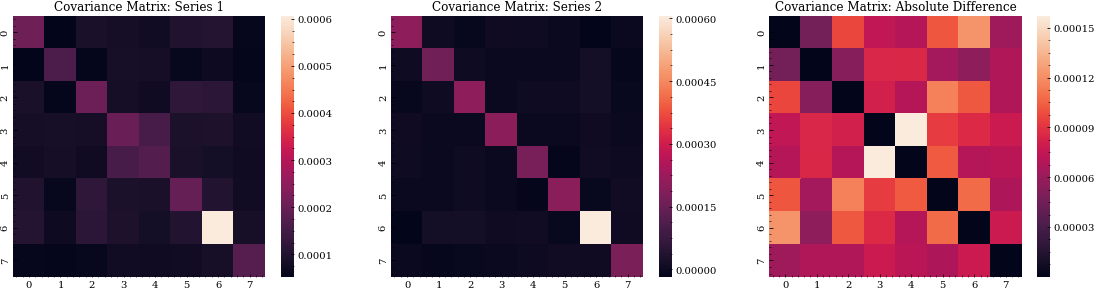

In [10]:
Moments.run(returns.values, returns_gen.values, render=True)

(False,
 {'first': (False,
   array([1.23409089, 0.74213152, 1.24390201, 0.87564377, 0.19438146,
          1.14687676, 0.80952845, 0.99773478])),
  'second': (False, 2.8491730669890405)})

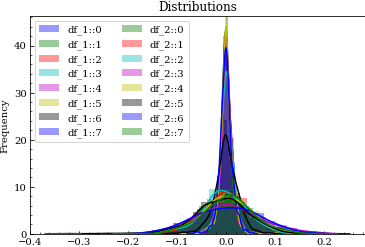

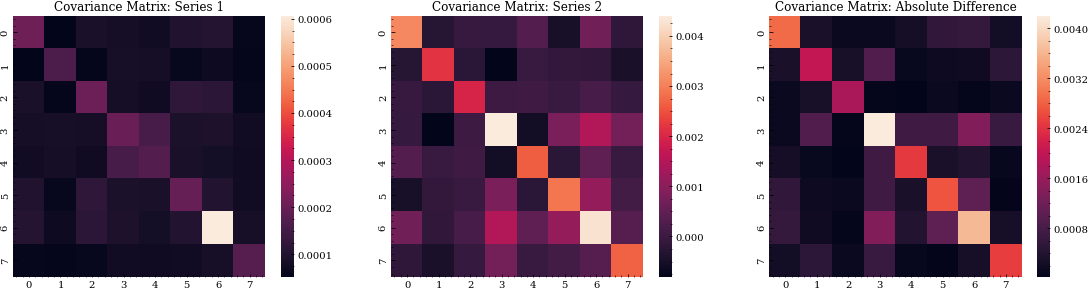

In [11]:
Moments.run(returns.values, returns_vae_gen, render=True)

### Rolling Moments



(False,
 {'first': (False,
   array([ 2.80036012,  1.77019445, 24.62924638,  0.33531207,  3.60566499,
           2.44729507, 15.09194198,  1.85436744])),
  'second': (False, 0.6844355121125033)})

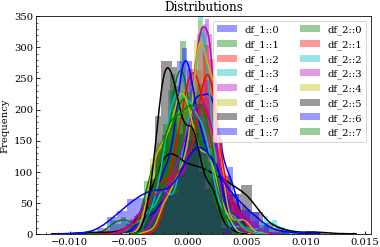

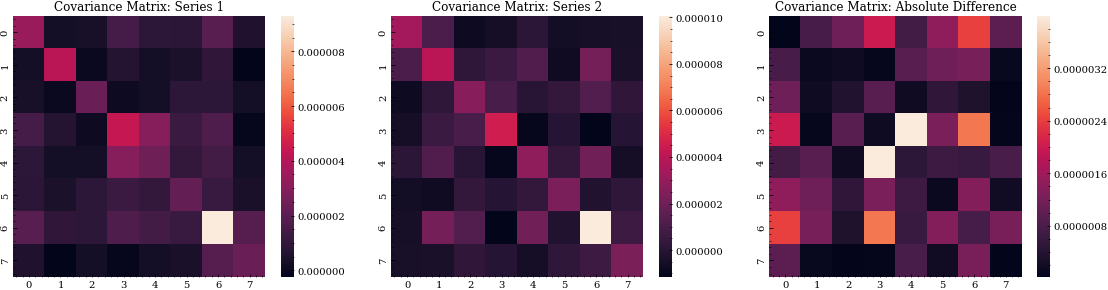

In [12]:
Moments.run(rolling_returns, rolling_returns_gen, render=True)

### Statistical Arbitrage



INFO:qtrader:New agent <qtrader.agents.quadratic.QuadraticAgent object at 0x11c9cd208> registered in <TradingEnv instance>
INFO:qtrader:New agent <qtrader.agents.random.RandomAgent object at 0x11d0808d0> registered in <TradingEnv instance>
INFO:qtrader:New agent <qtrader.agents.quadratic.QuadraticAgent object at 0x11b1bf9e8> registered in <TradingEnv instance>
INFO:qtrader:New agent <qtrader.agents.random.RandomAgent object at 0x11b1bf1d0> registered in <TradingEnv instance>


False

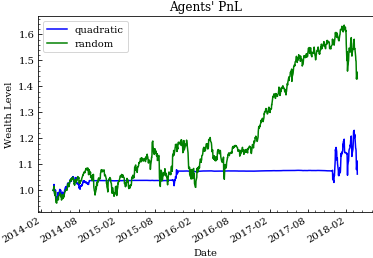

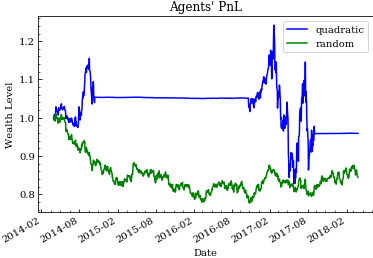

In [13]:
Arbitrage.run(returns, returns_gen,
              config['tickers'], config['freq'], config['window'], render=True)